## 1.Setup

In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import skimage
import os
from skimage.color import rgb2hsv
from skimage.color import rgb2gray
import scipy.misc
import imageio
import pandas as pd
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage import img_as_ubyte
import cv2
from scipy import ndimage
from sklearn.utils import resample

In [2]:
#data path
DISNEY_DIR = "images_disney"
HAYAO_DIR = "images_hayao"

## 2.Feature extraction

In [3]:
def calc_stats(fname):
    img =  io.imread(fname)
    denoi_img= cv2.fastNlMeansDenoisingColored(img) # get the denoised image
    hsv_img = rgb2hsv(denoi_img) # get the hsv image
    hue_img = hsv_img[:, :, 0] #get the hues
    saturation_img = hsv_img[:,:, 1] #get the saturations
    value_img = hsv_img[:, :, 2] #get the values
    ent_img = entropy(rgb2gray(denoi_img), disk(5)) #get the entropy
    sobel_x = ndimage.sobel(value_img, axis=0, mode='constant')
    sobel_y = ndimage.sobel(value_img, axis=1, mode='constant')
    edge_image = np.hypot(sobel_x, sobel_y) # get the edges
    return [img.shape[1],img.shape[0],np.mean(hue_img),np.mean(saturation_img),np.mean(value_img),np.mean(ent_img),np.sum(edge_image)/edge_image.size]

In [4]:
# Read the images and extract their width, height, mean_hue, mean_saturation, mean_value, mean_entropy and sum of edges
files = os.listdir(DISNEY_DIR)
stats = []
for fname in files:
    if 'jpg' in fname:
        stats.append(calc_stats(os.path.join(DISNEY_DIR , fname)))
    else:
        pass
# make a dataframe and save it into a csv file
disney_df = pd.DataFrame(stats)
disney_df.columns = ['width','height','mean_hue','mean_saturation','mean_value','mean_entropy','edge_sum']
disney_df.to_csv('disney_pics.csv')
disney_df.head()

C:\Users\27810\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


,width,height,mean_hue,mean_saturation,mean_value,mean_entropy,edge_sum
0,67,98,0.272307,0.148943,0.831144,3.778824,0.819642
1,99,99,0.346913,0.500670,0.275656,4.424552,0.585586
2,99,99,0.453854,0.168975,0.484728,4.181699,0.481131
3,99,99,0.351184,0.669260,0.497502,4.214874,0.554411
4,99,99,0.136235,0.926444,0.331088,3.405405,0.365691


In [5]:
# We do the same for Hayao images as what we do for Disney images
files = os.listdir(HAYAO_DIR)
stats = []
for fname in files:
    if 'jpg' in fname:
        stats.append(calc_stats(os.path.join(HAYAO_DIR , fname)))
    else:
        pass
hayao_df = pd.DataFrame(stats)
hayao_df.columns = ['width','height','mean_hue','mean_saturation','mean_value','mean_entropy','edge_sum']
hayao_df.to_csv('hayao_pics.csv')
hayao_df.head()

,width,height,mean_hue,mean_saturation,mean_value,mean_entropy,edge_sum
0,67,98,0.281277,0.530815,0.231668,3.895495,0.583236
1,99,99,0.273528,0.405424,0.722306,4.257138,0.662596
2,147,100,0.600145,0.325997,0.711840,3.021263,0.270850
3,147,100,0.507668,0.685993,0.552678,3.737993,0.201171
4,147,100,0.154216,0.728086,0.574216,4.672342,0.498490


## 3.Ploting the features

In [42]:
# We will do a bootstrap to test if our features of two different groups of data differ
def bootstrap(values):
    # do a 1000 times bootstraps and return the (lower bound of CI, mean, upper bound of CI)
    n_iterations = 1000
    n_size = int(len(values) * 0.50)
    # bootstrap
    stats = list()
    for i in range(n_iterations):
        sample = resample(values, n_samples=n_size)
        stats.append(np.mean(sample))
    alpha = 0.95
    p = ((1.0-alpha)/2.0) * 100
    lower =np.percentile(stats, p)
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = np.percentile(stats, p)
    return (lower, np.mean(stats), upper)

### 3.1 Size

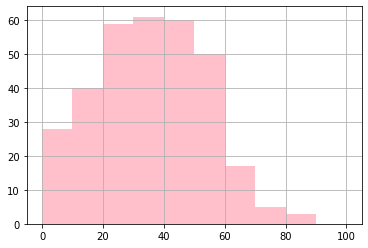

In [6]:
disney_df.apply(lambda x: x[1]*x[2],axis = 1).hist(color = 'pink', range = (0,100))

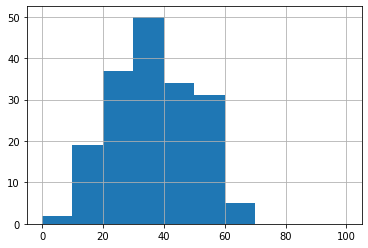

In [7]:
hayao_df.apply(lambda x: x[1]*x[2],axis = 1).hist(range = (0,100))

By comparing the histogram of the two datasets' size, we know that the images of these two different groups are roughly within the same range: 0-100. So the size of the images won't affect our prediction model we are building.

### 3.2 Hue

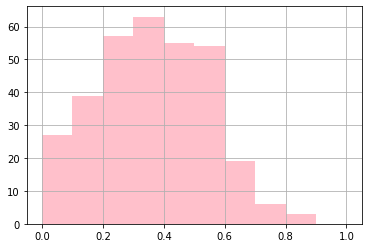

In [9]:
disney_df.mean_hue.hist(range = (0,1),color = 'pink')

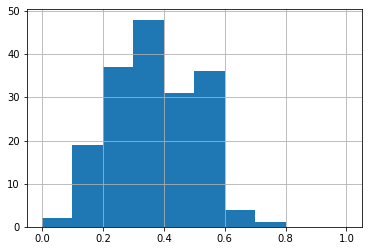

In [11]:
hayao_df.mean_hue.hist(range=(0,1))

In [24]:
bootstrap(disney_df.mean_hue)

(0.3362422115799134, 0.36244843448901165, 0.3904269745772894)

In [23]:
bootstrap(hayao_df.mean_hue)

(0.3404681955944216, 0.3699101708554919, 0.3964980647930884)

Dayao's pictures' mean hue is similar to Disney Studio's. Disney's pictures' mean hue are slightly smaller, but it's not significant

### 3.3 Saturation

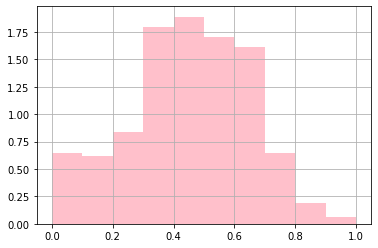

In [28]:
disney_df.mean_saturation.hist(range = (0,1), density = True, color = 'pink')

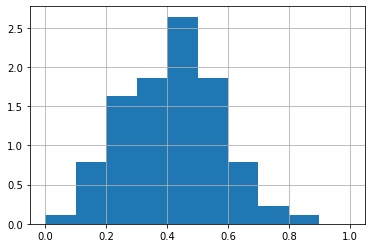

In [30]:
hayao_df.mean_saturation.hist(range = (0,1),density = True)

In [31]:
bootstrap(disney_df.mean_saturation)

(0.4148868285858349, 0.44606984995314647, 0.47699558863821845)

In [32]:
bootstrap(hayao_df.mean_saturation)

(0.3809160086029047, 0.4151984483595519, 0.45042216318599304)

The values of mean satuartion of disney pictures is apparently larger than hayao's. It shows that it's more possible for a picture to be from Disney Studio with higher satauration

### 3.4 Value

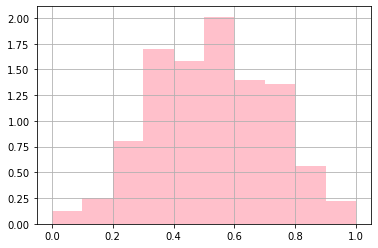

In [33]:
disney_df.mean_value.hist(range = (0,1), density = True, color = 'pink')

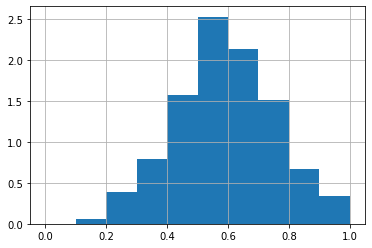

In [34]:
hayao_df.mean_value.hist(range = (0,1),density = True)

In [36]:
bootstrap(disney_df.mean_value)

(0.4955476931602786, 0.5266626172315388, 0.5554149012551444)

In [37]:
bootstrap(hayao_df.mean_value)

(0.5531429742148872, 0.5861746523739747, 0.6197098872979893)

The mean values of pictures from Hayao set are much larger than those from Disney. It is to say that the pictures from Hayao is more likely to have a higher mean value

### 3.5 Entropy

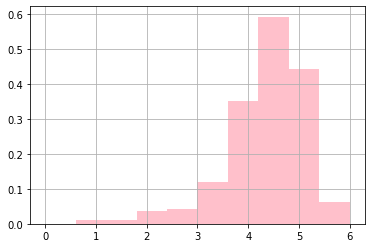

In [38]:
disney_df.mean_entropy.hist(range = (0,6),density = True, color = 'pink')

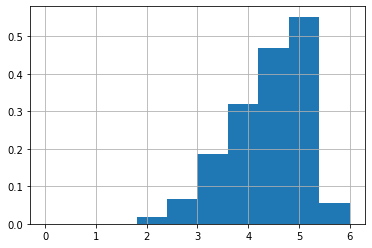

In [39]:
hayao_df.mean_entropy.hist(range = (0,6),density = True)

In [43]:
bootstrap(disney_df.mean_entropy)

(4.240572329436668, 4.3601163189652095, 4.481373087527604)

In [44]:
bootstrap(hayao_df.mean_entropy)

(4.207502520418425, 4.373622788817749, 4.526509702771563)

The two groups of pictures share a rouhgly same mean entropy. It means that mean entropy might not be a feature with significant meaning.

### 3.6 Edges

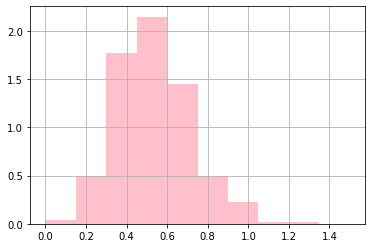

In [45]:
disney_df.edge_sum.hist(range = (0,1.5),density = True, color = 'pink')

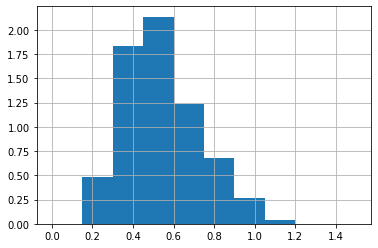

In [46]:
hayao_df.edge_sum.hist(range = (0,1.5),density = True)

In [47]:
bootstrap(disney_df.edge_sum)

(0.5048678342946722, 0.533140548038868, 0.5617216838244802)

In [48]:
bootstrap(hayao_df.edge_sum)

(0.5096039940039852, 0.5451134009773144, 0.5846290190430762)

The picutres of disney studio have a slightly smaller sum of edges which might show a little bit significance that might determine 